In [1]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from math import comb             # для подсчета коэффициентов
import matplotlib.pyplot as plt     # для отрисовки
from decimal import Decimal         # для отрисовки

# knapsack problem
# !git clone https://github.com/madcat1991/knapsack.git
import os
import sys
sys.path.insert(0, os.getcwd())
sys.path.insert(0, os.getcwd() + '/knapsack')
from knapsack.fptas import FPTAS

######################################################
# data reader
# нужно дать ссылку на папку из датасета
######################################################
def graph_read(filename = "topologies_with_traffic/germany50"):
    nodes = pd.read_csv(f"{filename}/Node.csv")
    topology = pd.read_csv(f"{filename}/topo.csv")

    costs_dict = defaultdict(lambda: defaultdict(lambda: {}))
    for line in topology.iterrows():
        index, src, dst, cap, cost = int(line[1][0]), int(line[1][1]), int(line[1][2]), line[1][3], line[1][4]
        costs_dict[src][dst] = {'capacity': cap, 'cost':cost, 'index': index}
    rez = nx.DiGraph(costs_dict)
    return rez, costs_dict, topology

##########################################################
# Shapley Value
##########################################################
def C_n_k(n, k):
     return comb(n, k)

def SV(graph, source, dest, val_func):
    for edge in graph.edges:  graph.edges[edge]['value'] = 0.
    n = len(graph.edges)
    for path in nx.all_simple_edge_paths(graph, source, dest):
        G = graph.edge_subgraph(path)
        rez = val_func(G, source, dest)
        
        rez = rez / C_n_k(n-1, len(path) - 1) / n

        for edge in path: graph.edges[edge]['value']  += rez
    return graph

##########################################################
# val_func 
# функция рассчета для графа
##########################################################
def val_func(graph, source, dest):
    try:
        rez = nx.maximum_flow(graph, source, dest, capacity='capacity')[0]
        return rez
    except:
        return 0

    

In [2]:
path = "topologies_with_traffic/germany50"   # путь до описания графа из нашего датасета
graph, costs_dict, topology = graph_read(path)
# SV(graph, 1, 21, val_func)

In [63]:
filename =  "topologies_with_traffic/germany50"
nodes = pd.read_csv(f"{filename}/Node.csv")
topology = pd.read_csv(f"{filename}/topo.csv")

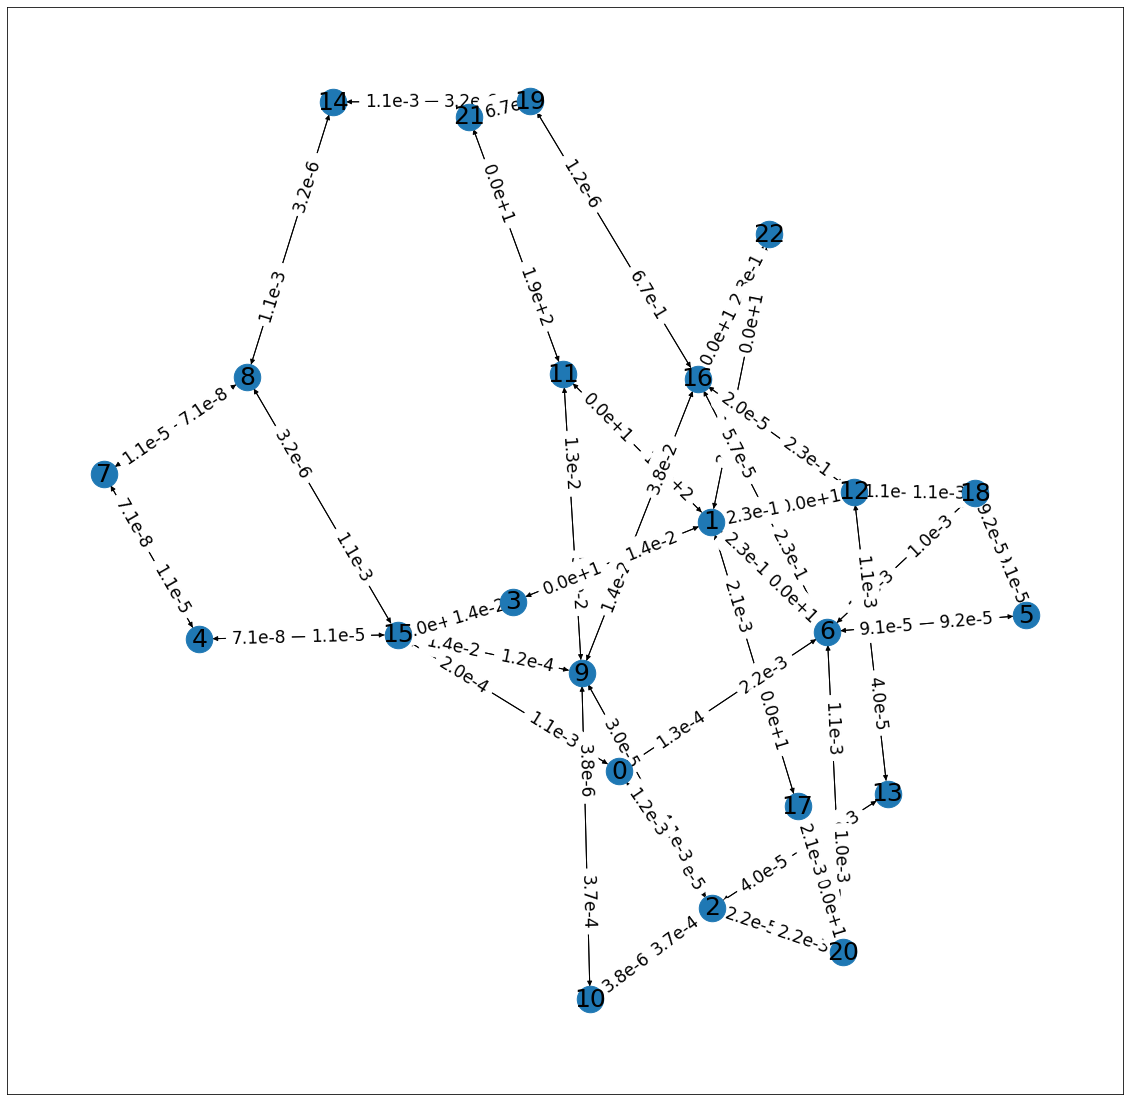

In [64]:
figure = plt.figure(figsize = (20, 20))
pos = nx.spring_layout(graph)      # закомменировано чтобы сохранить расположение вершин

edge_labels = {t: f"{Decimal(graph.edges[t]['value']):.1e}" for t in graph.edges}
nx.draw_networkx(graph, pos = pos, node_size = 700, with_labels= True, font_size = 25)
not_print = nx.draw_networkx_edge_labels(graph, pos = pos, edge_labels = edge_labels, font_size = 17, label_pos=0.7)

knapsack solve


6
1000000.0


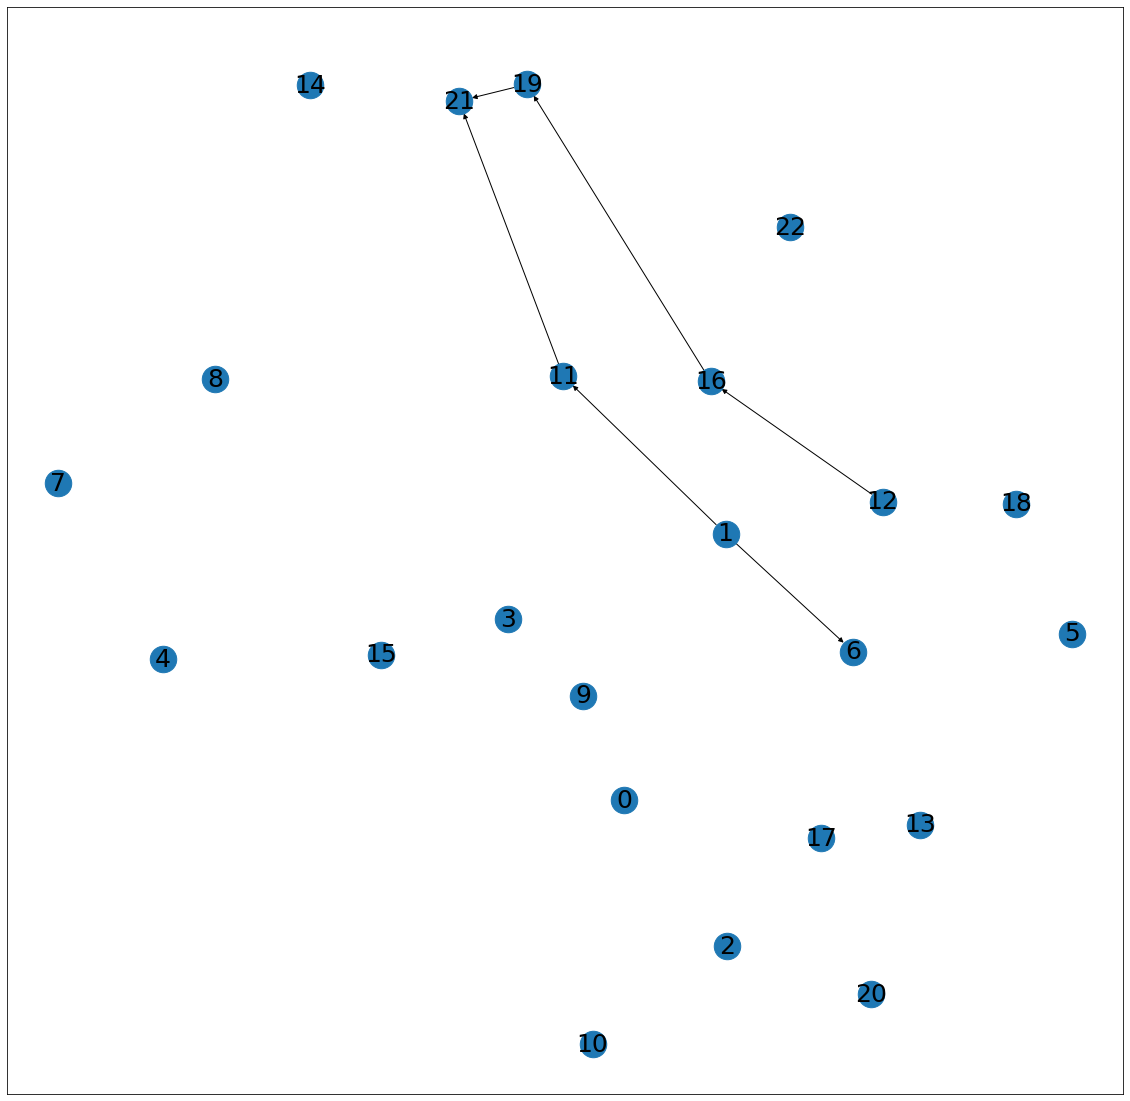

In [65]:
capasity = 25       # вместимость ---> бюджет 

input = [(edge[2]['cost'], edge[2]["value"]) for edge in graph.edges.data()]

number = len(input)
scaling_factor = 0.02

rez = FPTAS(number, capasity, input, scaling_factor)  # возвращает one_hot вектор ребер которые попали в рюкзак
new_graph = graph.copy()
new_graph.remove_edges_from([(node[0], node[1]) for num, node in enumerate(graph.edges.data()) if rez[1][num] == 0])

print(sum(rez[1]))
print(val_func(new_graph, 1, 21))

figure = plt.figure(figsize = (20, 20))
nx.draw_networkx(new_graph, pos = pos, node_size = 700, with_labels= True, font_size = 25)

Greed search 

2-nd way

In [82]:
from math import inf
def SV_solution_search(graph, source, dest, max_cost: float = 0) -> list:
    rez = [] #список ребер которые попадают в результат
    current_edges = list(graph.edges(source)) #список ребер, которые сейчас находятся в рассмотрении
    used_nodes = {i: 0 for i in graph.nodes}
    used_nodes[source] = 1
    current_price = 0.

    def sort_func(i):
        value = graph.edges[current_edges[i]]['value']
        cost = graph.edges[current_edges[i]]['cost']
        if current_price + cost <= max_cost:
            return value
        else:
            return -inf
    while current_price < max_cost:
        next = max(range(len(current_edges)), key= lambda x: sort_func(x))
        if sort_func(next) == -inf:
            break
        rez.append(current_edges[next])
        current_price += graph.edges[current_edges[next]]['cost']
    # обновление current_edges и used_nodes
        new_node = current_edges[next][1]
        current_edges.__delitem__(next)
        if used_nodes[new_node] == 0:
            used_nodes[new_node] = 1
            current_edges = current_edges + list(graph.edges(new_node))
        if len(current_edges) == 0:
            break
    return rez


1000000.0


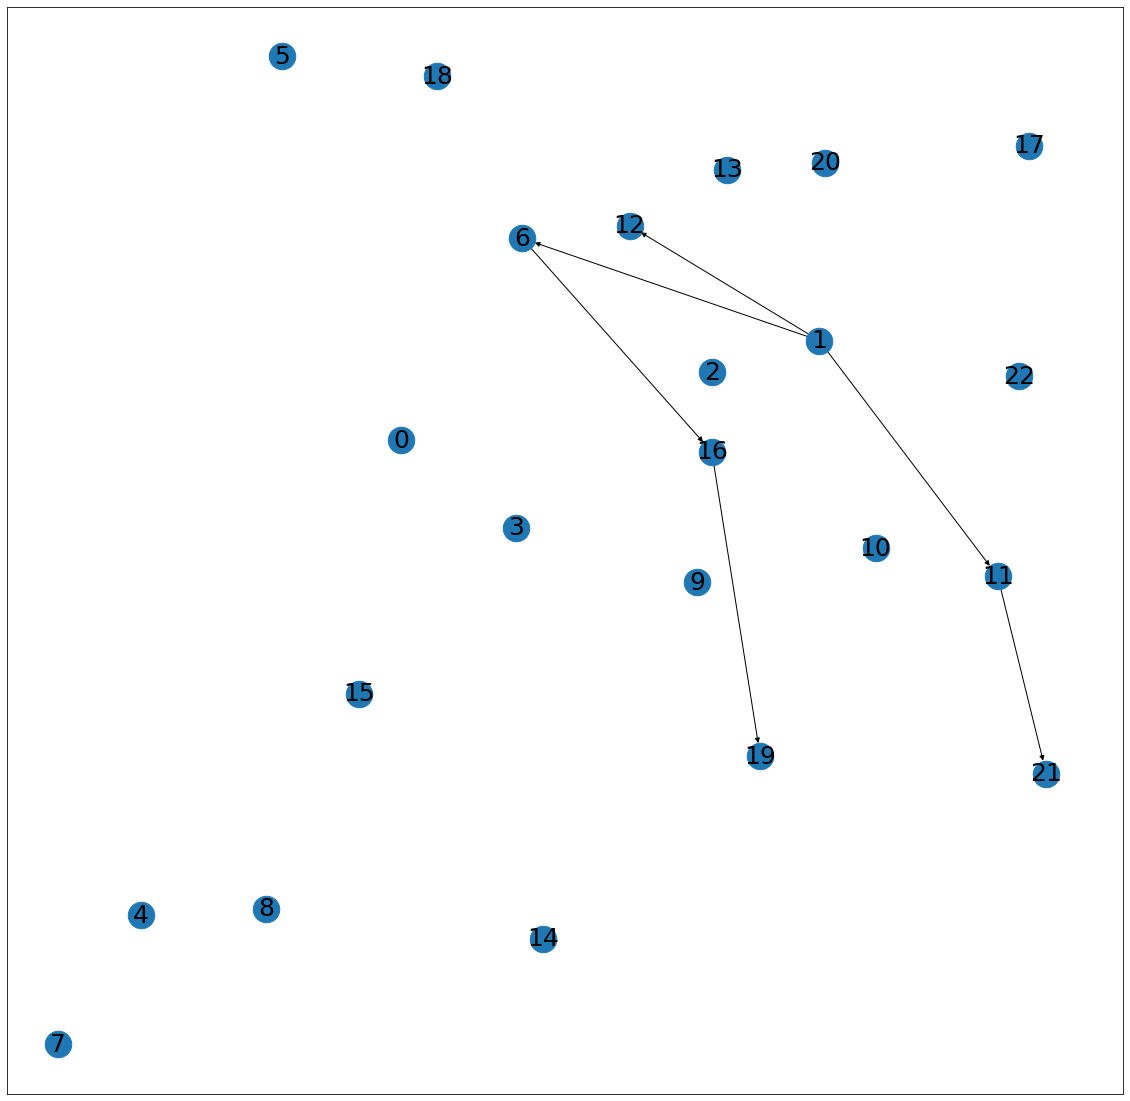

In [103]:
edges = SV_solution_search(graph, 1, 21, 25)

new_graph = graph.copy()
new_graph.remove_edges_from(list(set(graph.edges()) - set(edges)))

print(val_func(new_graph, 1, 21))
# pos = nx.spring_layout(new_graph) 
figure = plt.figure(figsize = (20, 20))
nx.draw_networkx(new_graph, pos = pos, node_size = 700, with_labels= True, font_size = 25)

Gradient search


In [3]:
from copy import deepcopy
import numpy as np
import cvxpy as cp

class Func:
    def __init__(self, graph, src, dst, h = 0.01):
        self.graph = deepcopy(graph)
        self.src = src
        self.dst = dst
        self.h = h

    def val_func(self):
        try:
            rez = nx.maximum_flow(self.graph, self.src, self.dst, capacity='capacity_tmp')[0]
            return rez
        except:
            return 0


    def grad(self, u):
        if len(u) != self.graph.number_of_edges():
            raise ValueError(f"число параметров должно совпадать с числом ребер")
        for num, edge in enumerate(self.graph.edges):  self.graph.edges[edge]['capacity_tmp'] = self.graph.edges[edge]['capacity'] * u[num]
        gradient = np.zeros_like(u)
        tmp = self.val_func()
        for num, edge in enumerate(self.graph.edges):
            self.graph.edges[edge]['capacity_tmp'] = self.graph.edges[edge]['capacity'] * (u[num] + self.h)
            gradient[num] = (self.val_func() - tmp) / self.h
            # print(gradient[num])
            self.graph.edges[edge]['capacity_tmp'] = self.graph.edges[edge]['capacity'] * u[num]      
        return gradient

def projection(u, p, graph, max_cost, cost_vector):
    k = (1-u)**p
    x = cp.Variable(u.shape, pos = True)
    func = cp.Minimize(cp.sum((x - k) **2))
    constraints = [x <= 1, cp.sum(cost_vector* x) >= np.sum(cost_vector) - max_cost]
    problem = cp.Problem(func, constraints)
    problem.solve()
    if problem.status == "optimal":
        return 1 - x.value ** (1/p)
    else:
        raise ValueError("не удалось спроецировать на множество")


In [43]:
from warnings import filterwarnings
from tqdm import tqdm
filterwarnings('ignore')

src, target = 1, 21

func =Func(graph, src, target)


u = np.ones(graph.number_of_edges())

cost_vect = np.array([graph.edges[edge]['cost'] for edge in graph.edges])
max_cost = 100000
iter_per_epoch = 50
epochs = 10
gamma = 0.01
for p in range(1, epochs + 1):
    u = projection(u, p, graph, max_cost, cost_vect)
    for i in tqdm(range(iter_per_epoch)):
        grad = func.grad(u)
        grad = grad  / np.max(grad)
        grad = projection(grad, p, graph, max_cost, cost_vect) 
        u = u * (1 - gamma) + gamma * grad
p = epochs
# чтобы сделать бОльше шагов на последнем внутреннем штрафе 
iters = 100
for i in tqdm(range(iters)):
        grad = func.grad(u)
        grad = grad  / np.max(grad)
        grad = projection(grad, p, graph, max_cost, cost_vect) 
        u = u * (1 - gamma) + gamma * grad

100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


минимальная цена для получения максимального потока: 293580.0
стоимость после фильтрации: 80120.0


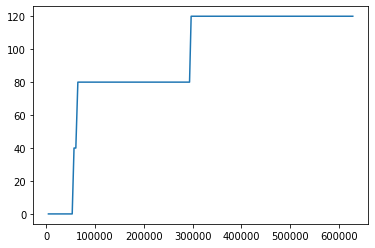

In [47]:
def filter_edges(graph, src, target):
    try:
        remove_edges = []
        rez = nx.maximum_flow(graph, src, target, capacity='capacity')
        for key, value in rez[1].items():
            for key1, value1 in value.items():
                if abs(value1) < 1e-1:   ### тут нужно продумать как выставлять границу
                    remove_edges.append((key, key1))
        graph.remove_edges_from(remove_edges)
        graph
    except:
        return 0

array = sorted([(edge, cost_vect[num], u[num])  for num, edge in enumerate(graph.edges)], key = lambda x: x[2])
arr = [i[0] for i in array]
cost_vect_sorted =  [i[1] for i in array]
cost = []
value = []
for i in range(2, len(arr)):
    new_graph = deepcopy(graph)
    new_graph.remove_edges_from(arr[:i])
    value.append(val_func(new_graph, src, target))
    cost.append(np.sum(cost_vect_sorted[i:]))
plt.plot(cost, value)

i = np.argmin(np.array(value) >= val_func(graph, src, target))
print(f"минимальная цена для получения максимального потока: {cost[i]}")

new_graph = deepcopy(graph)
new_graph.remove_edges_from(arr[:i])
filter_edges(new_graph, src, target)
print(f"стоимость после фильтрации: {sum(new_graph.edges[edge]['cost'] for edge in new_graph.edges)}")


In [41]:
new_graph.edges[28,44]['cost']

3290.0

минимальная цена для получения максимального потока: 630080.0


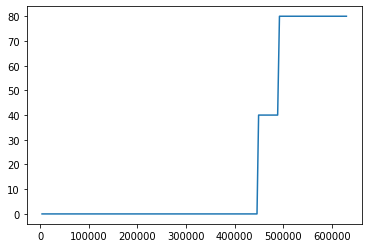

In [10]:
arr = sorted([(edge, cost_vect[num], u[num])  for num, edge in enumerate(graph.edges)], key = lambda x: x[2])
arr = [i[0] for i in arr]
cost_vect_sorted =  [i[1] for i in arr]
cost = []
value = []
for i in range(2, len(arr)):
    new_graph = deepcopy(graph)
    new_graph.remove_edges_from(arr[:i])
    value.append(val_func(new_graph, src, target))
    cost.append(np.sum(cost_vect[i:]))
plt.plot(cost, value)

print(f"минимальная цена для получения максимального потока: {cost[np.argmin(np.array(value) >= val_func(graph, src, target))]}")

value: 2000000.0
cost: 427.0


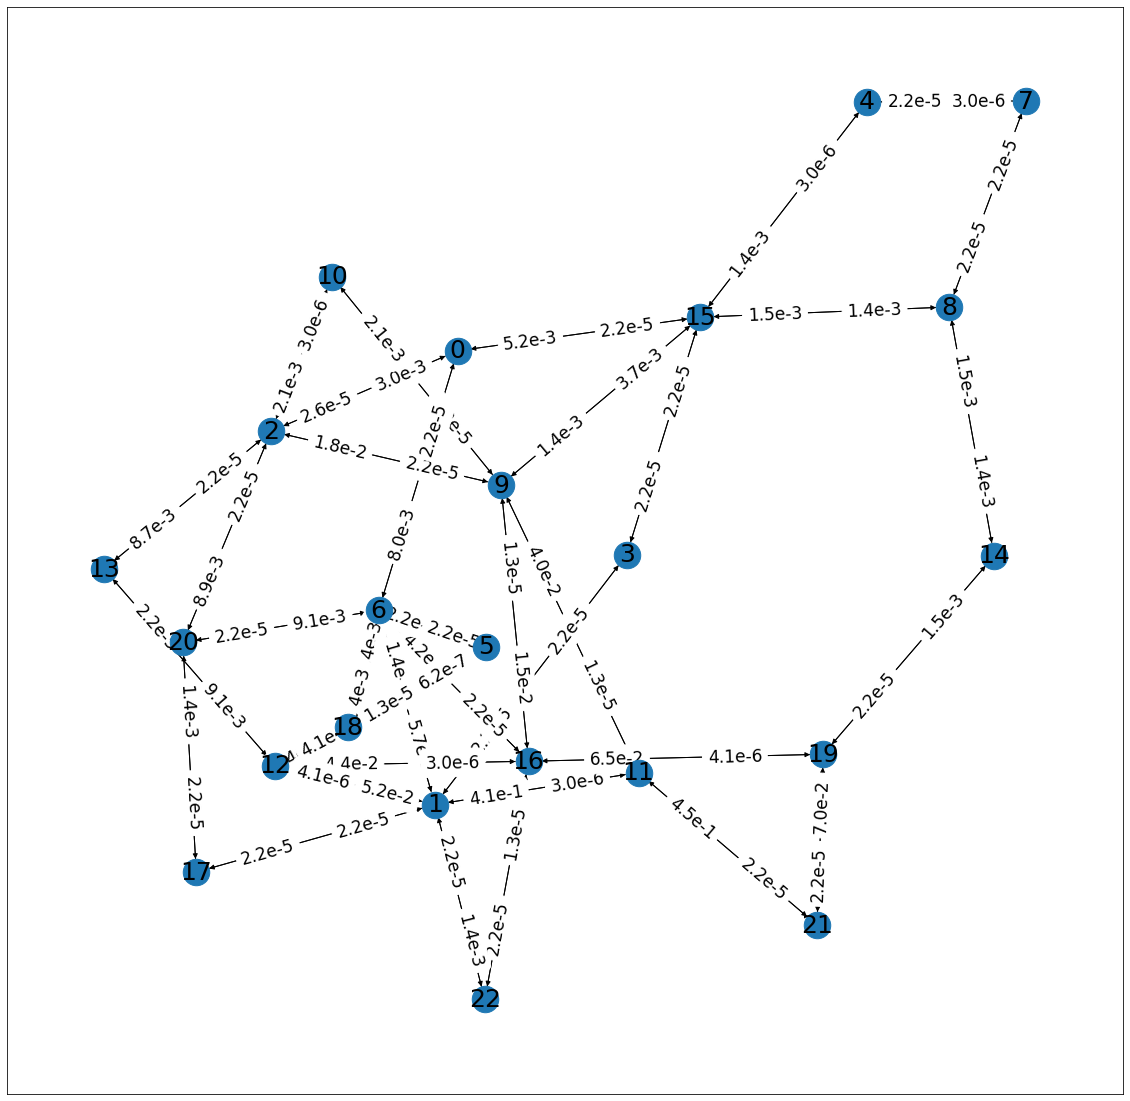

In [98]:
figure = plt.figure(figsize = (20, 20))

tmp_gr = 0.0
edge_labels = {t: f"{Decimal(u[num]):.1e}" for num, t in enumerate(graph.edges) if u[num] > tmp_gr}

new_graph = deepcopy(graph)
delete_edges = [edge for num, edge in enumerate(graph.edges) if u[num] < tmp_gr]
new_graph.remove_edges_from(delete_edges)

print(f"value: {val_func(new_graph, 1, 21)}")
print(f"cost: {np.sum(cost_vect[u >= tmp_gr])}" )
pos = nx.spring_layout(new_graph)      # закомменировано чтобы сохранить расположение вершин
nx.draw_networkx(new_graph, pos = pos, node_size = 700, with_labels= True, font_size = 25)
not_print = nx.draw_networkx_edge_labels(new_graph, pos = pos, edge_labels = edge_labels, font_size = 17, label_pos=0.7)

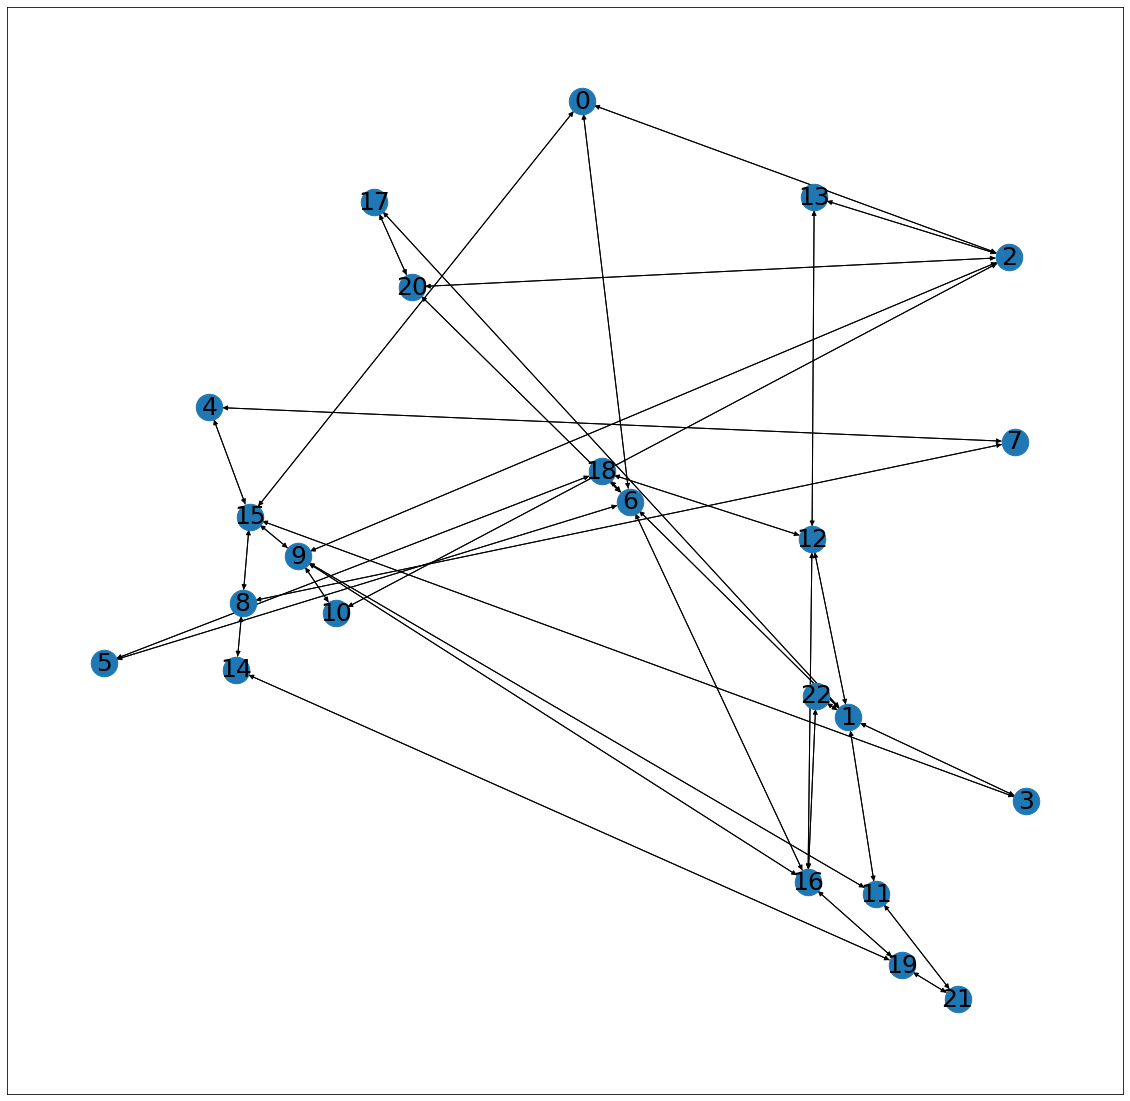

In [87]:
figure = plt.figure(figsize = (20, 20))
nx.draw_networkx(graph, pos = pos, node_size = 700, with_labels= True, font_size = 25)

In [213]:
nx.maximum_flow(graph, 1, 21, capacity='capacity')[0]

120.0

In [211]:
graph.edges[12,14]

{'capacity': 40.0, 'cost': 3290.0, 'index': 0}